# Lesson 3 - RFM

## Author - Lukas Fiorio

This project uses data from Tableau Public on Customer transactions to compute RFM (Recency, Frequency, Monetary Value) and then segment customer orders through kmeans clustering.
The data can be found and downloaded here: 
- https://community.tableau.com/s/contentdocument/0694T000001GnpUQAS

For this project, we download the data from a link made available through University of Washington.
- https://library.startlearninglabs.uw.edu/DATASCI420/2019/Datasets/SuperstoreTransaction.csv

#### Abstract

Our data consists of \~10,000 products bought in ~5,000 orders made by ~800 customers from 2014-2017.  Our goal is to engineer new features to inform customer segmentation for promotional targeting.

Specifically, we aggregate product purchases to customer orders and compute RFM, then (kmeans) cluster those orders based on our new quantitative features measuring recency, frequency, and value.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import math

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from IPython.display import display
import textwrap

import scipy.stats as ss
import statsmodels.api as sm

In [2]:
# set package options
pd.set_option('display.max_columns', None) # show all columns
plt.rc('patch', force_edgecolor = True) # set bar borders in bar plots

## Read data

Our first step is to load the transaction data for analysis. 

The data is originally sourced from Tableau Public [(available here)](https://community.tableau.com/s/contentdocument/0694T000001GnpUQAS), although in this project we source directly through University of Washington.

In [3]:
# Locate & load dataset
file = "https://library.startlearninglabs.uw.edu/DATASCI420/2019/Datasets/SuperstoreTransaction.csv"
ss_txn = pd.read_csv(file) # read file into df

After loading, we next preview the data. We see about 10,000 transactions and 21 attributes.  Visually, it appears that most of the attributes are not numeric.

In [4]:
print(ss_txn.shape)
ss_txn.head()

(9994, 21)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


#### Data Structure

Explicitly examining our data structure shows that our data is indeed mostly string data.

Conveniently, we also see that there are no missing values in our data.

*NB: although `Postal Code` is parsed as numeric, we would treat it as categorical for any analytical purposes.*

In [5]:
ss_txn.info() # data structure

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

#### Data Grain and Feature Cardinality ####

Looking at unique values, we see that our data contains \~10,000 product transactions (`Row ID`) bought across \~5,000 orders (`Order ID`) made by \~800 customers (`Customer ID`).

Furthermore, we get a good sense of the cardinality of each column.

Those with low cardinality (e.g. `Ship Mode`, `Segment`, `Region`, etc.) may be good candidates for onehot encoding.  Those with high cardinality would likely need to be sensibly aggregated first (to avoid increasing the dimensionality of our data too significantly).

In [6]:
ss_txn.nunique() # count of unique values in each field

Row ID           9994
Order ID         5009
Order Date       1237
Ship Date        1334
Ship Mode           4
Customer ID       793
Customer Name     793
Segment             3
Country             1
City              531
State              49
Postal Code       631
Region              4
Product ID       1862
Category            3
Sub-Category       17
Product Name     1850
Sales            5825
Quantity           14
Discount           12
Profit           7287
dtype: int64

#### Numeric Attributes

Describing our numeric fields is really only useful for `Sales`, `Quantity`, `Discount`, and `Profit`.  We can't interpret much from the descriptive statistics of `Row ID` and `Postal Code`.

We see that a typical order (median) is about \\$55, with profit just under \$10.  Based on the max values, it looks like our data may skew right (as is typical for financial data).

We apply a lambda function to round the stats for readability.

In [7]:
ss_txn.describe().apply(lambda s: s.apply(lambda x: format(x, 'g'))) # data stats

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994,9994,9994,9994,9994,9994
mean,4997.5,55190.4,229.858,3.78957,0.156203,28.6569
std,2885.16,32063.7,623.245,2.22511,0.206452,234.26
min,1,1040,0.444,1,0,-6599.98
25%,2499.25,23223,17.28,2,0,1.72875
50%,4997.5,56430.5,54.49,3,0.2,8.6665
75%,7495.75,90008,209.94,5,0.2,29.364
max,9994,99301,22638.5,14,0.8,8399.98


### Data Prep

Next we'll clean up our column names and convert our date columns from objects to datetime fields

In [8]:
# rename columns for consistency
ss_txn.columns = ss_txn.columns.str.replace("-", "_") # replace hyphens
ss_txn.columns = ss_txn.columns.str.replace(" ", "_") # replace white space
ss_txn.columns = ss_txn.columns.str.lower() # lower case

# convert date columns to datetime (from object)
ss_txn['order_date'] = pd.to_datetime(ss_txn['order_date'])
ss_txn['ship_date'] = pd.to_datetime(ss_txn['ship_date'])

### Data Visualization

In this section we'll explore our dataset a bit.

First, we'll store the count of observations (transactions) by `order_date`.  From the preview, it looks like our transaction data spans from 2014 - 2017 (`.sort_index()` is used to ensure the date valus are sorted).

In [9]:
txn_count_daily = ss_txn['order_date'].value_counts().sort_index() # sort values
txn_count_daily

2014-01-03     1
2014-01-04     3
2014-01-05     1
2014-01-06     9
2014-01-07     2
              ..
2017-12-26     4
2017-12-27     2
2017-12-28    19
2017-12-29    12
2017-12-30     7
Name: order_date, Length: 1237, dtype: int64

#### Transaction Volume Trends

Plotting transaction counts by day, we get confirmation that our data spans from January 2014 thru December 2017 (4 years of transactions).  We also see that the data is pretty noisy (fairly volatile from day-to-day).

Applying a 14-day rolling average helps make the overall upward trend a bit more visible.  We also see some seasonal spikes in the latter parts of each year (September, November, December) before dropping back down in January.

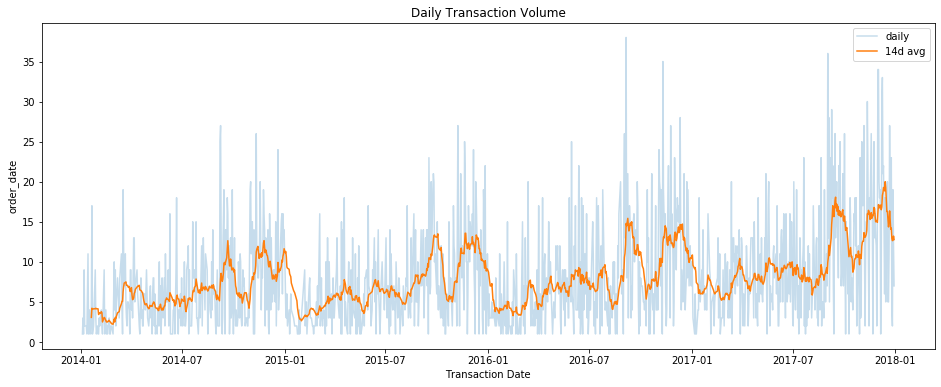

In [10]:
# set figure, axis properties
plt.figure(figsize = (16, 6))
plt.xlabel("Transaction Date")
plt.ylabel("Transaction Count")
plt.title("Daily Transaction Volume")

# draw line plots
sns.lineplot(x = txn_count_daily.index, y = txn_count_daily, alpha = 0.25, label = 'daily');
sns.lineplot(x = txn_count_daily.index, y = txn_count_daily.rolling(14).mean(), label = '14d avg');

#### Function: Feature Distributions

For a bit more exploration, we also define a function to show distributions of categorical and continuous variables.  Setting `plot_type` to `'distplot'` works best for continuous features, while `'countplot'` is more natural for categorical features.

In [11]:
def dist_plots(df, col_list, plot_type, n_cols=2):
    '''
    df: dataframe
    col_list: list of column names.
    plot_type: ['countplot', 'distplot']
    n_cols: number of columns in grid of plots. default = 2.
    '''
    
    # deduce nbr of rows needed for plot
    n_rows = math.ceil(len(col_list) / n_cols)

    # set figure, axis properties
    fig, ax = plt.subplots(ncols = n_cols, nrows = n_rows)
    fig.set_size_inches(16, 4 * n_rows)
    fig.tight_layout(h_pad = 6, w_pad = 12)
    
    params = {'kde': False} if plot_type == 'distplot' else {}

    # if one column only, plot just that one
    if len(col_list) == 1:
        sns.countplot(y = df[col_list[0]], ax = ax);
        ax.title.set_text('# of transactions, by ' + col_list[0]);
    
    # if multiple columns, loop & plot each
    else:
        # loop through each column & plot
        for i, col in enumerate(col_list):

            # compute row, col index
            i_row = math.floor(i / n_cols)
            i_col = i % n_cols

            # make plots
            getattr(sns, plot_type)(df[col], ax = ax[i_row][i_col], **params)
            ax[i_row][i_col].title.set_text('Transactions, by ' + col);

#### Categorical Features (low-cardinality)

Next, we identify categorical columns (those of type `'object'`), and then specifically our low-cardinality categorical columns for plotting.

In [12]:
# store object columns
obj_cols = ss_txn.select_dtypes(['object']).columns.tolist()

# count of unique values by column
ss_txn_nunique_obj = ss_txn[obj_cols].nunique().tolist()

# store object columns with cardinality of 2-10
obj_low_card = ss_txn[obj_cols].columns[
    np.where(
        (np.array(ss_txn_nunique_obj) >= 2) & 
        (np.array(ss_txn_nunique_obj) <= 10)
    )[0]]

#### Transaction Counts by Category

Transaction counts of categorical columns show that consumers are making the most purchases and office supplies are the most commonly purchased product types.

Slower shipping options are more common and region is relatively balanced (although a bit fewer purchases from customers in the South).

Does customer segment influence these other attributes at all? Are consumers more likely to buy office supplies than corporate?

We'll take a look at that next.

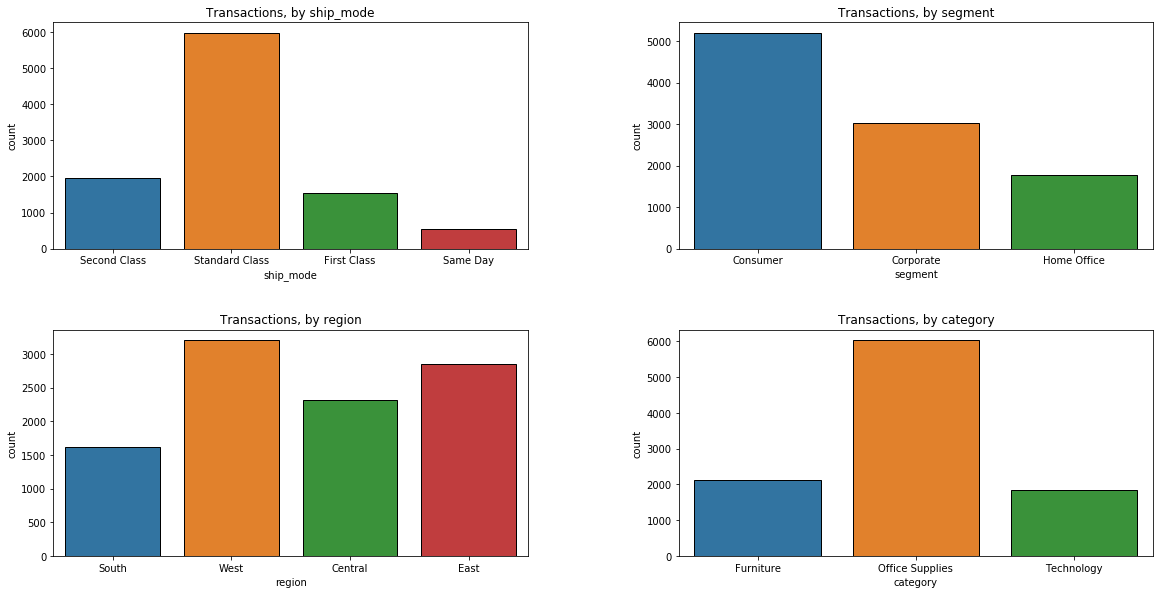

In [13]:
dist_plots(ss_txn, obj_low_card, plot_type = 'countplot', n_cols=2)

#### Function: Crosstab heatmaps

Let's define a function to make those comparisons by segment for us. To call the function, we provide a data frame, a list of columns, and the column (`segment`, in this case) to split by.

In [14]:
def ctab_heatmap(df, col_list, remove_col):

    # remove specified column from low-cardinality list (for crosstabs)
    col_list_ctab = col_list.tolist() # convert to list if not already
    col_list_ctab.remove(remove_col)

    # set figure properties
    fig, ax = plt.subplots(ncols = 3, nrows = 1)
    fig.set_size_inches(14, 8)
    fig.tight_layout(w_pad = 12)

    for i, col in enumerate(col_list_ctab):

        # calculate crosstabs
        ctab_txn_cnt = pd.crosstab(df[col], df[remove_col], margins = True, normalize = 'index')
        cbar_fmt = lambda x, pos: '{:.0%}'.format(x)

        # make plots
        sns.heatmap(ctab_txn_cnt, 
                    cmap = 'Blues', 
                    square = True, 
                    cbar_kws = {'shrink': 0.3, 'format': FuncFormatter(cbar_fmt)}, 
                    annot = True, 
                    fmt = '.0%',
                    linewidths = 1.0,
                    ax = ax[i]
                   );
        
        # set labels
        ax[i].title.set_text('Product Transaction Mix by segment\n Split by ' + col);
        ax[i].set_yticklabels(ax[i].get_yticklabels(), rotation = 0, fontsize = 12)
        ax[i].set_yticklabels(ax[i].get_yticklabels(), rotation = 0, fontsize = 12)

#### Transaction mix by segment

We see that there's not much difference in Product transaction mix between customer segments.  Overall, about 52% are made by consumers, 30% by corporate, and 18% by home office.

The only notable deviation that we see from that is on delivery type, where corporate is much less likely to use same day delivery than we'd otherwise expect.

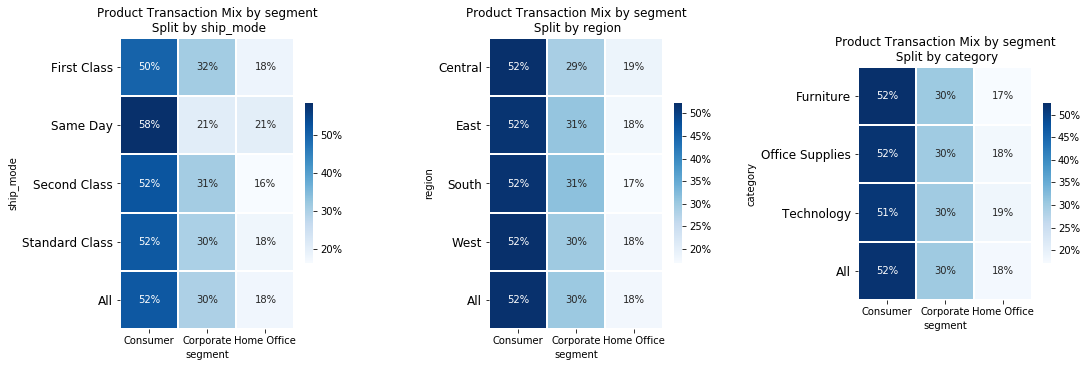

In [15]:
ctab_heatmap(ss_txn, obj_low_card, 'segment')

#### Numeric Features

And now let's also identify numeric columns to visualize those distributions.

The `row_id` and `postal_code` columns are both numeric, but we'll exclude them from our plots since those visualizations won't be helpful for us.

In [16]:
# store numeric columns; excluding row_id, postal_code
num_cols = ss_txn.select_dtypes(['float', 'int']).columns.tolist()
num_cols = list(set(num_cols) ^ set(['row_id', 'postal_code']))

#### Transaction Distribution by Numeric Features

Plotting numeric columns, we're able to learn a bit more about each.

The `discount` field appears to be a proportion between 0 and 1.  From the plot, the relationship between `sales` and `discount` isn't clear, but we can examine that next.  The primary question is whether the `sales` data is inclusive of the discount.

`profit` appears to be the closest to normally distributed and is centered just above 0 (most product transactions are profitable, although some are not).

`sales` and `quantity` both have long right tails.  `sales` in particular may be a candidate for log-transformation.

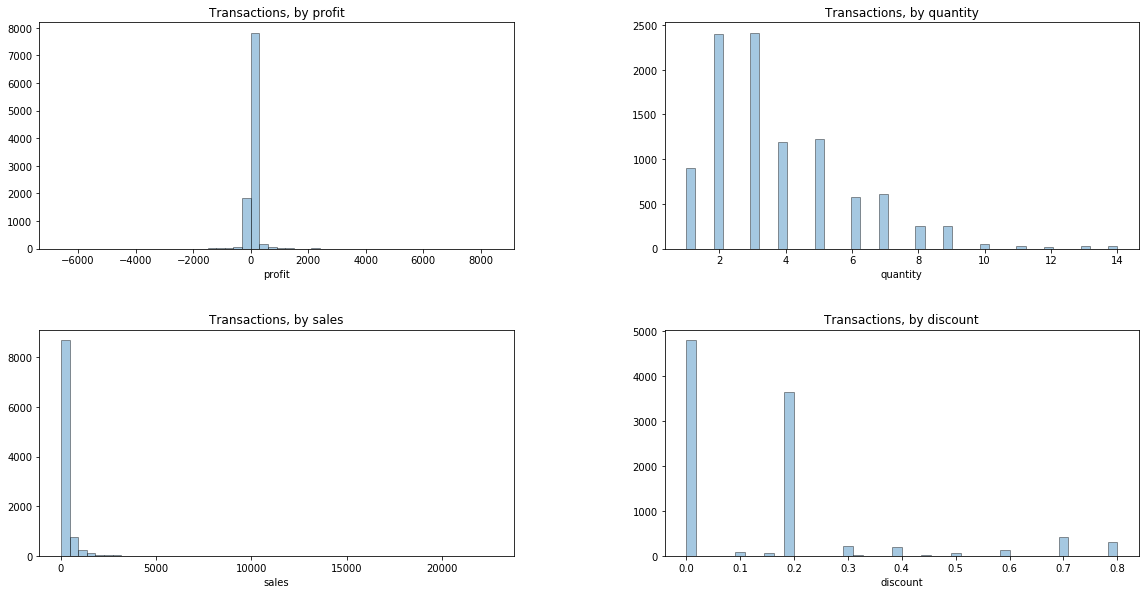

In [17]:
dist_plots(ss_txn, num_cols, plot_type = 'distplot', n_cols=2)

#### `discount` inclusion

Let's check whether the sales amount includes the discount or whether the discount still needs to be taken off.

We need to control for the number of products in each order, so we'll first calculate the per-unit price (as `product_price`).

Then we'll group by `product_id` and `discount` to see how product price varies based on the discount field.  Lastly, we'll also add a counter field for `product_id`, to make it a bit simpler to take subsets of product-level data.

In [18]:
# per unit price
ss_txn['product_price'] = ss_txn['sales'] / ss_txn['quantity']

# columns to group by & aggregate on
group_cols = ['product_id', 'product_name', 'discount']
agg_cols = ['product_price']

# aggregate by product, discount
product_discounts = ss_txn[group_cols + agg_cols].groupby(group_cols, as_index = False).mean()

# compute product_num (product_id counter field)
product_discounts['product_num'] = (product_discounts['product_id'].
                                    transform(lambda x: pd.CategoricalIndex(x).codes)) + 1

#### Discount <ins>is</ins> included the listed sales amounts

Now we can compare the product price on various products based on the discount field.  We'll plot product price for just the first 8 products in our dataset and inspect.

From the plots, we see that product price is **already** inclusive of the discount % off.  Going up one level, this means that the `sales` field is also already inclusive of the awarded `discount`.

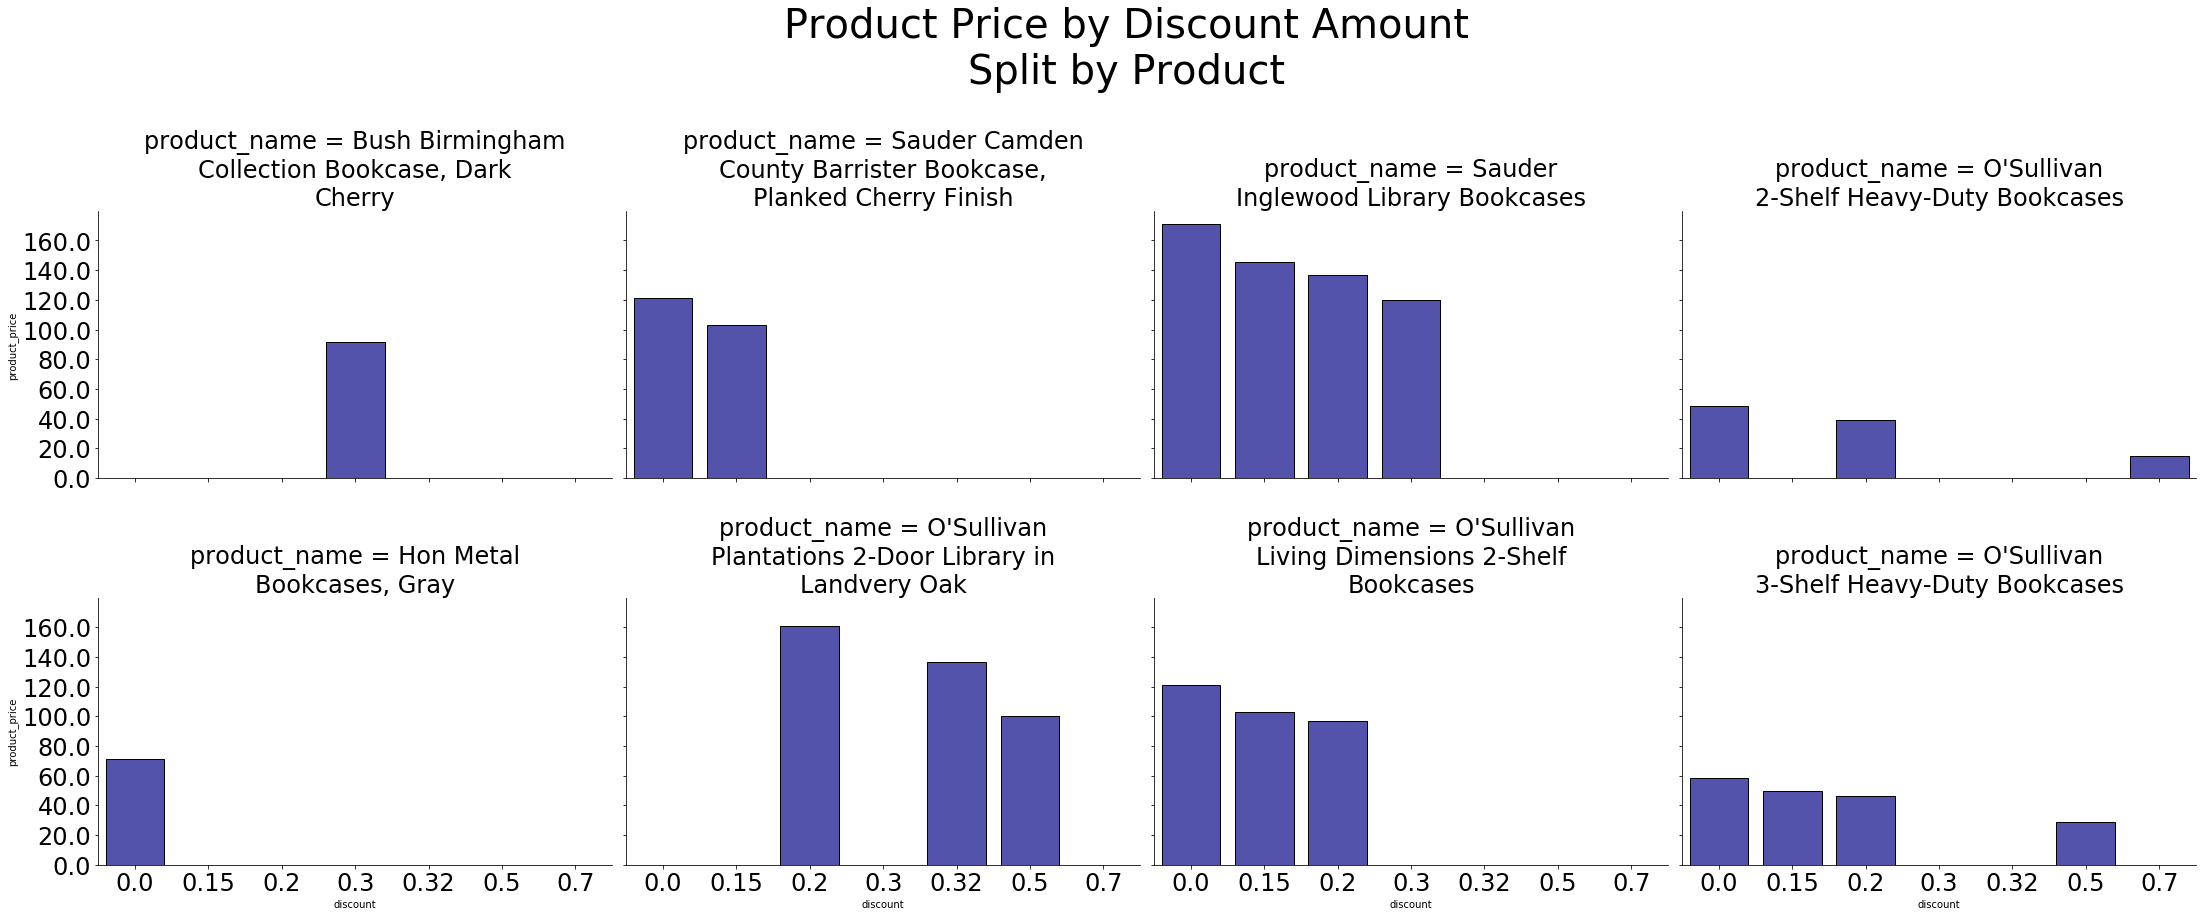

In [19]:
# make plot
ax = sns.catplot(data = product_discounts[product_discounts['product_num'] <= 8], 
            x = 'discount', y = 'product_price', 
            col = 'product_name', col_wrap = 4,
            kind = 'bar', color = 'blue', saturation = 0.35, aspect = 1.5);

# set facet grid height padding
ax.fig.tight_layout(h_pad = 10)

# set plot title
ax.fig.suptitle(
    'Product Price by Discount Amount\nSplit by Product', 
    fontsize = 40, 
    y = 1.25)

# adjust font sizes
for axes in ax.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), size = 24)
    axes.set_yticklabels(axes.get_yticks(), size = 24)
    axes.set_title(
        textwrap.fill(axes.get_title(loc = 'center'), 30), # wrap product name after 30 chars
        size = 24);

#### Function: Compare Numeric Field Distribution Fit

Now let's follow up on our numeric fields that were right skewed.

From our earlier inspection, we saw that the `product_price` and `sales` features in particular had long right tails.  Next we define a function to apply transformation functions (log and boxcox), then compare the original & transformed distributions to the normal distribution.

We'll make comparisons both statistically (using a kolmogorov-smirnov test) and visually.

In [20]:
# function to graphically and statistically compare distribution transformations
def compare_transformations(df, col, const=0):
    
    # set plot and axis properties
    fig, axs = plt.subplots(ncols = 3, nrows = 2)
    fig.set_size_inches(12, 8)
    fig.tight_layout(pad=6.0)
    axs[0][0].title.set_text('QQ plot: ' + col)
    axs[0][1].title.set_text('QQ plot: log(' + col + ')')
    axs[0][2].title.set_text('QQ plot: boxcox(' + col + ')')
    axs[1][0].title.set_text('distribution: ' + col)
    axs[1][1].title.set_text('distribution: log(' + col + ')')
    axs[1][2].title.set_text('distribution: boxcox(' + col + ')')

    # store transformations
    log_col = np.log(df[col] + const) # optionally specify a constant to avoid value=0 errors
    # ignore np.NaN warnings specifically for boxcox transformation
    with np.errstate(invalid='ignore'): 
        # optionally specify a constant to avoid value=0 errors
        boxcox_col = pd.Series(ss.boxcox(df[col] + const)[0])
    
    # make QQ plots
    sm.qqplot(df[col], line = 'q', ax = axs[0][0])
    sm.qqplot(log_col, line = 'q', ax = axs[0][1])
    sm.qqplot(boxcox_col, line = 'q', ax = axs[0][2])

    # make distribution plots
    sns.distplot(df[col], kde=False, ax = axs[1][0])
    sns.distplot(log_col, kde=False, ax = axs[1][1])
    sns.distplot(boxcox_col, kde=False, ax = axs[1][2]);
    
    # normalize columns for ks test
    z_col = (df[col] - df[col].mean()) / df[col].std()
    z_col_log = (log_col - log_col.mean()) / log_col.std()
    z_col_boxcox = (boxcox_col - boxcox_col.mean()) / boxcox_col.std()
 
    # print results of ks test
    print(col + ':')
    print(ss.kstest(z_col.dropna(), 'norm'))
    
    print('\nlog(' + col + '):')
    print(ss.kstest(z_col_log.dropna(), 'norm'))
    
    print('\nboxcox(' + col + '):')
    print(ss.kstest(z_col_boxcox.dropna(), 'norm'))

#### `product_price` distribution

H<sub>0</sub>: The sample **is** drawn from a Normal distribution.

Given the p-values, we reject that comparison.  Even after the log and box-cox transformations, it appears the tails are still too short to follow a normal distribution, although they are much closer.

product_price:
KstestResult(statistic=0.33582797782486207, pvalue=0.0)

log(product_price):
KstestResult(statistic=0.06858018603781352, pvalue=2.9764656010443995e-41)

boxcox(product_price):
KstestResult(statistic=0.059827603705515875, pvalue=1.697902840813396e-31)


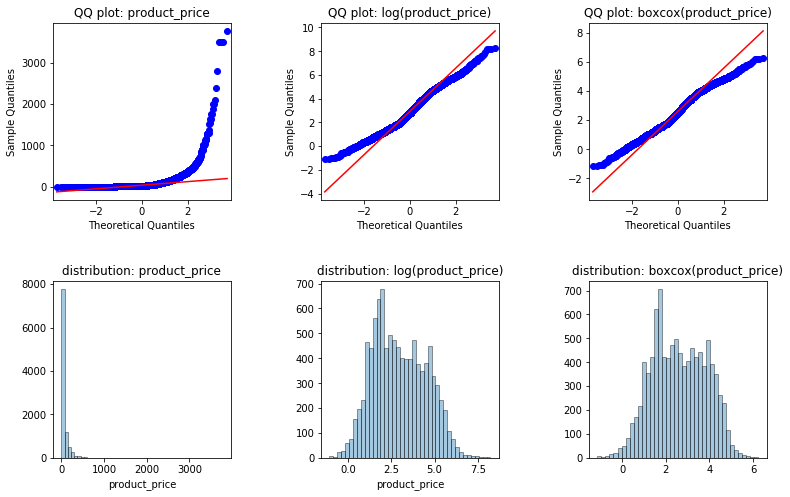

In [21]:
compare_transformations(ss_txn, 'product_price')

#### `sales` distribution

H<sub>0</sub>: The sample **is** drawn from a Normal distribution.

Similar to `product_price`, it appears that `sales` also does not follow a normal distribution even after the transformation (tails are still too short).

That said - **in both cases, the log and boxcox transformations noticeably improved the right skew of the distributions.**

sales:
KstestResult(statistic=0.35643523525465687, pvalue=0.0)

log(sales):
KstestResult(statistic=0.041039722258109645, pvalue=4.7920515614218105e-15)

boxcox(sales):
KstestResult(statistic=0.03368198451142412, pvalue=2.837973414233741e-10)


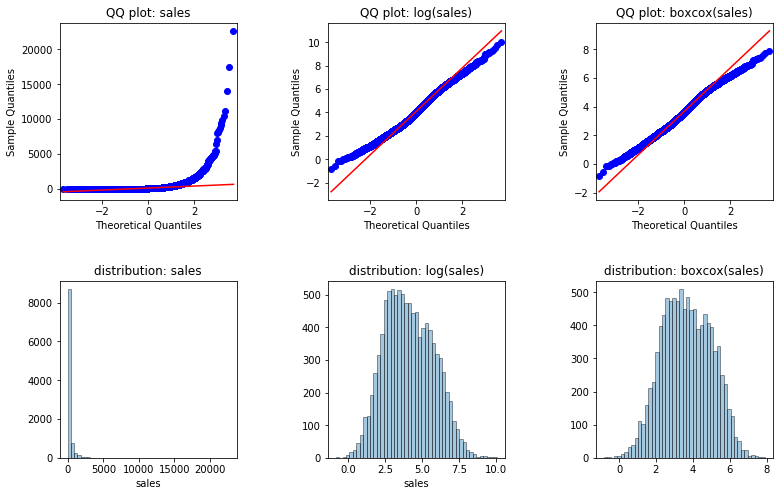

In [22]:
compare_transformations(ss_txn, 'sales')

### Calculate RFM

In [23]:
# group by customer id and order date
# aggregate $ sales, # of total products, # of distinct products, # of distinct orders
ss_txn_agg = ss_txn.groupby(['customer_id', 'order_date']).agg({
    'sales': 'sum',
    'quantity': 'sum', 
    'product_id': 'nunique',
    'order_id': 'nunique'
    })
ss_txn_agg = ss_txn_agg.reset_index()

Examining our new structure, we see we've aggregated down to about half the row count that we began with.

In [24]:
ss_txn_agg.head() # preview the data

,customer_id,order_date,sales,quantity,product_id,order_id
0,AA-10315,2014-03-31,726.548,4,2,1
1,AA-10315,2014-09-15,29.500,5,2,1
2,AA-10315,2015-10-04,26.960,2,1,1
3,AA-10315,2016-03-03,4406.072,14,4,1
4,AA-10315,2017-06-29,374.480,5,2,1


In [25]:
ss_txn_agg.info() # data structure

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4992 entries, 0 to 4991
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   customer_id  4992 non-null   object        
 1   order_date   4992 non-null   datetime64[ns]
 2   sales        4992 non-null   float64       
 3   quantity     4992 non-null   int64         
 4   product_id   4992 non-null   int64         
 5   order_id     4992 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 234.1+ KB


In [26]:
# examine records associated with an arbitrary customer
ss_txn_agg[ss_txn_agg['customer_id']=='CG-12520']

,customer_id,order_date,sales,quantity,product_id,order_id
869,CG-12520,2015-10-15,136.72,7,2,1
870,CG-12520,2016-11-08,993.90,5,2,1
871,CG-12520,2017-01-26,18.16,2,1,1


#### calculate rolling sums on aggregated data

In [27]:
# take rolling sums at each check point, examining past 90 days
roll_sum_sales = ss_txn_agg.groupby('customer_id').rolling(window = '90D', on = 'order_date')['sales'].sum()
roll_cnt_products = ss_txn_agg.groupby('customer_id').rolling(window = '90D', on = 'order_date')['quantity'].sum()
roll_cnt_products_distinct = ss_txn_agg.groupby('customer_id').rolling(window = '90D', on = 'order_date')['product_id'].sum()

In [28]:
# compute recency metric (days since customers last txn)
roll_last_order = ss_txn_agg.groupby('customer_id')['order_date'].diff(periods = 1).dt.days

# calculate max observed recency, for imputation
last_order_imputation = (ss_txn_agg['order_date'].max() - ss_txn_agg['order_date'].min()).days

In [29]:
# combine rolling sum and recency metrics
ss_txn_roll = pd.concat([roll_sum_sales, roll_cnt_products, roll_cnt_products_distinct], axis = 1)
ss_txn_roll.columns = ['dollar_roll_sum_90d', 'product_roll_sum_90d', 'distinct_product_roll_sum_90d']
ss_txn_roll = ss_txn_roll.reset_index()

# if first visit, fill w max date range
ss_txn_roll['last_visit_ndays'] = roll_last_order.fillna(last_order_imputation) 

In [30]:
# inner merge agg & roll (on customer_id, order_date)
ss_txn_rfm = ss_txn_agg.merge(
    ss_txn_roll, 
    how = "inner", 
    on = ['customer_id', 'order_date'], 
    validate = 'one_to_one'
    )

# preview rfm data
ss_txn_rfm.head()

,customer_id,order_date,sales,quantity,product_id,order_id,dollar_roll_sum_90d,product_roll_sum_90d,distinct_product_roll_sum_90d,last_visit_ndays
0,AA-10315,2014-03-31,726.548,4,2,1,726.548,4.0,2.0,1457.0
1,AA-10315,2014-09-15,29.500,5,2,1,29.500,5.0,2.0,168.0
2,AA-10315,2015-10-04,26.960,2,1,1,26.960,2.0,1.0,384.0
3,AA-10315,2016-03-03,4406.072,14,4,1,4406.072,14.0,4.0,151.0
4,AA-10315,2017-06-29,374.480,5,2,1,374.480,5.0,2.0,483.0


In [31]:
ss_txn_rfm.info() # data structure of rfm

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4992 entries, 0 to 4991
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_id                    4992 non-null   object        
 1   order_date                     4992 non-null   datetime64[ns]
 2   sales                          4992 non-null   float64       
 3   quantity                       4992 non-null   int64         
 4   product_id                     4992 non-null   int64         
 5   order_id                       4992 non-null   int64         
 6   dollar_roll_sum_90d            4992 non-null   float64       
 7   product_roll_sum_90d           4992 non-null   float64       
 8   distinct_product_roll_sum_90d  4992 non-null   float64       
 9   last_visit_ndays               4992 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(3), object(1)
memory usage: 429.0+ KB


## Segment using kmeans

#### Make a copy of the dataset to handle numeric outliers/normalization for KMeans

In [32]:
# make a copy of the dataset (no pointer)
ss_txn_rfm_scaled = ss_txn_rfm.copy()

#### Normalize the data

- This is important for kmeans as it is a distance-based algorithm
- select relevant numeric columns and z-scale them for use in kmeans
- if data are not scaled, then distances will not be appropriately weighted

In [33]:
# normalize the data
scale_cols = ss_txn_rfm_scaled.columns.difference(['customer_id', 'order_date'], sort = False)
ss_txn_rfm_scaled[scale_cols] = StandardScaler().fit_transform(ss_txn_rfm_scaled[scale_cols]) 

#### initialize & fit kmeans

In [34]:
n_clusters = 2 # set number of clusters

X = ss_txn_rfm_scaled[scale_cols]
kmeans = KMeans(n_clusters = n_clusters, random_state = 0) # initialize kmeans
kmeans.fit(X) # train the model

KMeans(n_clusters=2, random_state=0)

In [35]:
# assign cluster to each row of the original RFM data
ss_txn_rfm['cluster'] = kmeans.predict(X) 

In [36]:
ss_txn_rfm.head() # preview the data

,customer_id,order_date,sales,quantity,product_id,order_id,dollar_roll_sum_90d,product_roll_sum_90d,distinct_product_roll_sum_90d,last_visit_ndays,cluster
0,AA-10315,2014-03-31,726.548,4,2,1,726.548,4.0,2.0,1457.0,0
1,AA-10315,2014-09-15,29.500,5,2,1,29.500,5.0,2.0,168.0,0
2,AA-10315,2015-10-04,26.960,2,1,1,26.960,2.0,1.0,384.0,0
3,AA-10315,2016-03-03,4406.072,14,4,1,4406.072,14.0,4.0,151.0,1
4,AA-10315,2017-06-29,374.480,5,2,1,374.480,5.0,2.0,483.0,0


### Examine and describe cluster centers

- **cluster**: <ins>*Large, Frequent Transaction Days*</ins>
  - The smaller cluster (23% of observations).  Defining characteristic: Larger, more frequent transaction days
  - Transactions consist of more products and items
    - However, the item::product ratio is similar to the other cluster, indicating that larger transaction size is primarily driven by the # of distinct products purchased (not a higher # of each product)
  - Transactions are more frequent, although not overwhelmingly so.
  - Larger rolling window spend, but mostly (not entirely) driven by the transaction itself.
- **cluster**: <ins>*Small, Infrequent Transaction Days*</ins>
  - The larger cluster (77% of observations).  Defining characteristic: Smaller, less frequent transaction days
  - As opposed to the other cluster, these transactions tend to be smaller (due to fewer products purchased), and a bit less frequent.

In [37]:
# examine cluster centers
pd.DataFrame(kmeans.cluster_centers_, columns=scale_cols)

,sales,quantity,product_id,order_id,dollar_roll_sum_90d,product_roll_sum_90d,distinct_product_roll_sum_90d,last_visit_ndays
0,-0.226494,-0.373551,-0.376214,-0.022648,-0.260411,-0.402840,-0.393806,0.046687
1,0.750739,1.238176,1.247001,0.075069,0.863160,1.335256,1.305312,-0.154748


In [38]:
# relative size of each cluster
round(ss_txn_rfm['cluster'].value_counts(normalize = True).sort_index(), 2)

0    0.77
1    0.23
Name: cluster, dtype: float64

In [39]:
# columns to examine means by cluster
display(ss_txn_rfm.groupby(['cluster']).mean())

,sales,quantity,product_id,order_id,dollar_roll_sum_90d,product_roll_sum_90d,distinct_product_roll_sum_90d,last_visit_ndays
cluster,,,,,,,,
0,243.171932,5.256524,1.467380,1.002088,334.811032,7.081681,1.966075,413.542797
1,1177.039670,15.284483,3.761207,1.007759,1642.979568,21.880172,5.461207,313.300000
